In [3]:
import pandas as pd
import math
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
# from rdkit.Chem import rdChemReactions
from IPython.display import display
import pandas as pd
import gc

In [4]:
df = pd.read_csv('/home/iboiko/suffering/ord_data_mapped.csv', delimiter='\t')
df.head()

/tmp/ipykernel_1815234/985507707.py:1: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/iboiko/suffering/ord_data_mapped.csv', delimiter='\t')


,ID,Dataset,Date,ReactionSmiles,Yield,ReactionSmilesClean,BadMolecules,ReactantSize,ProductSize,mapped_rxn,confidence
0,ord-46edb6218f3e4b30b9edbc3778d033c4,uspto-grants-1994_10,NaN,[CH:1]1[C:6]([C:7]2[C:16](=[O:17])[C:15]3[C:14...,NaN,O=C1C(C2=CC=C(O)C=C2)=COC2=C1C(O)=CC(O)=C2.O=C...,NaN,42,17,NaN,0.0
1,ord-e02e86c6722649c19d1c4d8e45a67838,uspto-grants-1994_10,NaN,Br[C:2]1[CH:9]=[CH:8][C:5]([C:6]#[N:7])=[CH:4]...,93.0,N#CC1=CC=C(Br)C=C1.CCCCCC.[Li]CCCC.COB(OC)OC.C...,NaN,32,11,NaN,0.0
2,ord-fbf2878a83214f49ba4bde529b07025e,uspto-grants-1994_10,NaN,[C:1]([C:3]1[CH:8]=[CH:7][C:6](B(O)O)=[CH:5][C...,30.0,N#CC1=CC=C(B(O)O)C=C1.CCCCCCCSC1=CC=C(Br)C=C1....,NaN,39,22,NaN,0.0
3,ord-e568e5d0066b41319b6f746c5f56d61a,uspto-grants-1994_10,NaN,[Br:1][C:2]1[CH:7]=[CH:6][C:5]([SH:8])=[CH:4][...,NaN,SC1=CC=C(Br)C=C1.CCCCCBr.[OH-].[Na+].O>>CCCCCS...,NaN,17,13,NaN,0.0
4,ord-6fa6bac77d8e48b4b2e1665e7f37e885,uspto-grants-1994_10,NaN,[CH2:1]([S:6][C:7]1[CH:12]=[CH:11][C:10](Br)=[...,NaN,CCCCCSC1=CC=C(Br)C=C1.[Mg].II.O=S([O-])S(=O)(=...,NaN,26,13,NaN,0.0


In [5]:
df.shape

(2265056, 11)

In [6]:
new_df = df.dropna(subset=['Yield'], how='all')
new_df.shape

(940866, 11)

In [7]:
new_df.head()

,ID,Dataset,Date,ReactionSmiles,Yield,ReactionSmilesClean,BadMolecules,ReactantSize,ProductSize,mapped_rxn,confidence
1,ord-e02e86c6722649c19d1c4d8e45a67838,uspto-grants-1994_10,NaN,Br[C:2]1[CH:9]=[CH:8][C:5]([C:6]#[N:7])=[CH:4]...,93.000000,N#CC1=CC=C(Br)C=C1.CCCCCC.[Li]CCCC.COB(OC)OC.C...,NaN,32,11,NaN,0.0
2,ord-fbf2878a83214f49ba4bde529b07025e,uspto-grants-1994_10,NaN,[C:1]([C:3]1[CH:8]=[CH:7][C:6](B(O)O)=[CH:5][C...,30.000000,N#CC1=CC=C(B(O)O)C=C1.CCCCCCCSC1=CC=C(Br)C=C1....,NaN,39,22,NaN,0.0
6,ord-5a030c97fd674e7d94b450d6c638b3e6,uspto-grants-1994_10,NaN,[CH2:1]([C:4]1[CH:9]=[CH:8][C:7](C#C)=[CH:6][C...,123.400002,C#CC1=CC=C(CCC)C=C1.CCCCCSC1=CC=C(I)C=C1.CCNCC...,NaN,31,14,NaN,0.0
20,ord-6b762dd0417b4f4e8cfeb37ae62400fd,uspto-grants-1994_10,NaN,[CH2:1]([OH:10])[C:2]([CH2:4][O:5]P(O)(O)=O)=[...,30.000000,O=C(CO)COP(=O)(O)O.[N-]=[N+]=NC(C=O)CO.[OH-].[...,NaN,30,14,NaN,0.0
22,ord-bbb9d39e511b426daffd167319c568a7,uspto-grants-1994_10,NaN,O1CCCC1.[CH3:6][C:7]([N:16]1[CH2:20][C:19]([CH...,87.599998,C1CCOC1.CC1(CBr)CN(C(C)(C)C2=CC(Cl)=CC=C2)C(=O...,NaN,36,25,NaN,0.0


In [8]:
smi_vec = new_df["ReactionSmiles"]
len(smi_vec)


940866

In [9]:
def split_list(data, num_chunks):
    chunk_size = len(data) // num_chunks
    chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]
    # Adjust the last chunk to include any remaining elements
    if len(chunks) > num_chunks:
        last_chunk = chunks.pop() + chunks.pop()
        chunks.append(last_chunk)
    return chunks

def str_to_reaction(reaction_smiles, batch_size=200):
    container = []
    total = len(reaction_smiles)  # Total number of reactions to process
    for i in range(0, total, batch_size):
        batch = reaction_smiles[i:i + batch_size]
        for str_smiles in batch:
            reaction = AllChem.ReactionFromSmarts(str_smiles)
            container.append(reaction)
        # Calculate and display the progress as a percentage
        processed = min(i + batch_size, total)
        progress = (processed / total) * 100
        del batch
        gc.collect()
        print(f"Processed {processed}/{total} ({progress:.2f}%) reactions.", end='\r')
    print("\nProcessing complete.")
    return container


def filter_reactions_with_fluorine_in_products(reactions):
    # Define the substructure for fluorine
    fluorine = Chem.MolFromSmiles('F')
    
    # List to hold the reactions where fluorine is present in the products
    reactions_with_fluorine = []
    
    # Iterate over each reaction object in the list
    for reaction in reactions:
        # Extract products from the reaction
        product_templates = [reaction.GetProductTemplate(i) for i in range(reaction.GetNumProductTemplates())]
        
        # Check if fluorine is in any of the products
        if any(prod.HasSubstructMatch(fluorine) for prod in product_templates if prod):
            # If fluorine is found, add the original reaction to the list
            reactions_with_fluorine.append(reaction)
    
    return reactions_with_fluorine


In [10]:
chunks = split_list(smi_vec, 20)

In [11]:
len(chunks)

20

In [12]:
reactions = str_to_reaction(chunks[1])

Processed 47043/47043 (100.00%) reactions.
Processing complete.


In [13]:
fluor_compounds = filter_reactions_with_fluorine_in_products(reactions)
len(fluor_compounds)

11329

In [12]:
for i in range(0, min(10, len(fluor_compounds))):
    reaction_smiles = AllChem.ReactionToSmiles(fluor_compounds[i])
    print(f"Reaction {i+1}: {reaction_smiles}")

Reaction 1: CO[C:11]([C:3]1=[C:2]([F:1])[CH:7]=[N:6][C:5]2=[C:4]1[CH:10]=[CH:9][NH:8]2)=[O:12].[Al+3].[H-].[H-].[H-].[H-].[Li+]>C1CCOC1>[F:1][C:2]1=[CH:7][N:6]=[C:5]2[C:4](=[C:3]1[CH2:11][OH:12])[CH:10]=[CH:9][NH:8]2
Reaction 2: [F:1][C:2]1=[CH:7][N:6]=[C:5]2[C:4](=[C:3]1[CH2:11][OH:12])[CH:10]=[CH:9][NH:8]2>C1CCOC1.[Mn+4].[O-2].[O-2]>[F:1][C:2]1=[C:3]([CH:11]=[O:12])[C:4]2=[C:5]([N:6]=[CH:7]1)[NH:8][CH:9]=[CH:10]2
Reaction 3: I[I:13].[F:1][C:2]1=[C:3]([CH:11]=[O:12])[C:4]2=[C:5]([N:6]=[CH:7]1)[NH:8][CH:9]=[CH:10]2.[I-].[Na+].[Na+].[OH-]>CCO.OS(=O)[O-].[Na+]>[F:1][C:2]1=[C:3]([CH:11]=[O:12])[C:4]2=[C:5]([N:6]=[CH:7]1)[NH:8][CH:9]=[C:10]2[I:13]
Reaction 4: Cl[S:23]([C:20]1=[CH:19][CH:18]=[C:17]([CH3:16])[CH:22]=[CH:21]1)(=[O:24])=[O:25].[F:1][C:2]1=[C:3]([CH:12]=[O:13])[C:4]2=[C:5]([N:6]=[CH:7]1)[NH:8][CH:9]=[C:10]2[I:11].[Na+].[OH-]>CCOC(C)=O.CN(C)C=O>[F:1][C:2]1=[C:3]([CH:12]=[O:13])[C:4]2=[C:5]([N:6]=[CH:7]1)[N:8]([S:23]([C:20]1=[CH:19][CH:18]=[C:17]([CH3:16])[CH:22]=[CH:21]1)(=[O:24

# My code

In [13]:
import rxnutils

### This does not really work as intended but could be investigated further

In [118]:
from rdkit import Chem

# Assuming fluor_compounds[0] contains a ChemicalReaction object
reaction = reactions_with_dast[0]

# Initialize reactant matchers
reaction.Initialize()
reaction.RemoveUnmappedReactantTemplates()

# Get the atom maps for the reacting atoms
reacting_atoms = set()
for atom_map in reaction.GetReactingAtoms():
    reacting_atoms.add(atom_map[0])

# Filter out atoms that are not directly involved in the reaction
changed_atoms = set()
for product in reaction.GetProducts():
    product_atoms = set([atom.GetIdx() for atom in product.GetAtoms()])
    changed_atoms |= product_atoms

# Intersect the sets to obtain the final set of reacting atoms
react_center = reacting_atoms & changed_atoms

# Print reacting atoms
print(react_center)


{7}


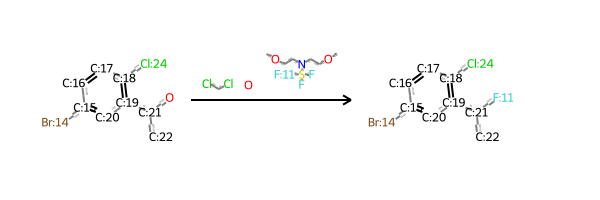

In [119]:
    # Generate a drawing of the reaction
img = Draw.ReactionToImage(reaction)

    # Display the image in a Jupyter notebook or similar environment
display(img)

In [114]:
# Assuming fluor_compounds[0] contains a ChemicalReaction object
reaction = reactions_with_dast[0]

# Initialize reactant matchers
reaction.Initialize()
reaction.RemoveUnmappedReactantTemplates()

In [120]:
from rxnutils.chem.reaction import *
import rdkit
from rdkit.Chem import *
reaction = rxnutils.chem.reaction.ChemicalReaction(rdkit.Chem.rdChemReactions.ReactionToSmiles(reaction))
reaction.generate_reaction_template()

(<rxnutils.chem.template.ReactionTemplate at 0x7f3e9bcd58d0>,
 <rxnutils.chem.template.ReactionTemplate at 0x7f3e9bcd6190>)

In [121]:
reaction.generate_reaction_template(radius=1)
reaction.canonical_template.smarts

'C-O-C-C-N(-C-C-O-C)-S(-F)(-F)-[F;H0;D1;+0:1].O-[CH;D3;+0:2](-[C;D1;H3:3])-[c:4]>>[C;D1;H3:3]-[CH;D3;+0:2](-[F;H0;D1;+0:1])-[c:4]'

In [124]:
template

AttributeError: 'ChemicalReaction' object has no attribute 'generate_coreagent'

### The problem is that dast is fully included in the template

In [29]:
import CGRtools
# import chython
import pandas as pd
from CGRtools.files import SMILESRead, SDFWrite
from CGRtools.containers import MoleculeContainer, QueryContainer, QueryCGRContainer, ReactionContainer
from CGRtools.containers.bonds import DynamicBond
from CGRtools.periodictable import ListElement, DynamicQueryElement, DynamicQueryC
from pickle import loads, dumps

import rdkit
from rdkit.Chem import *

In [21]:
smiles_parser = SMILESRead.create_parser(ignore=True)

In [58]:
mapped_data = []
for rxn in reactions_with_dast:
    reaction = smiles_parser(rdkit.Chem.rdChemReactions.ReactionToSmiles(rxn))
    mapped_data.append(reaction)

In [36]:
mapped_data[0].clean2d()
mapped_data[0]

In [59]:
cgrs=[]
for r in mapped_data:
    cgr=r.compose()
    cgrs.append(cgr)
cgrs[0]

In [39]:
cgrs[0].centers_list

((24, 9, 21, 1),)

In [43]:
query = cgrs[0].augmented_substructure(cgrs[0].center_atoms, deep=1)
query.clean2d()
query

In [44]:
query = cgrs[0].augmented_substructure(cgrs[0].center_atoms, deep=0)
query.clean2d()
query

In [45]:
cgrs[0] > query

True

In [49]:
rule = QueryCGRContainer()
rule.add_atom("O", 1)
rule.add_atom("C", 2)
rule.add_atom("F", 3)

3

In [50]:
rule.add_bond(1, 2, DynamicBond(1, None))
rule.add_bond(2, 3, DynamicBond(None, 1))

In [51]:
rule.clean2d()
rule

In [52]:
cgrs[0] > rule

True

## Now the real work 

In [63]:
mapped_data = []
for rxn in fluor_compounds:
    reaction = smiles_parser(rdkit.Chem.rdChemReactions.ReactionToSmiles(rxn))
    mapped_data.append(reaction)

In [64]:
cgrs=[]
for r in mapped_data:
    cgr=r.compose()
    cgrs.append(cgr)
cgrs[0]

In [65]:
match_rule = []
for cgr in cgrs:
    if cgr > rule:
        match_rule.append(cgr)

len(match_rule) 

29

In [66]:
match_rule[0].clean2d()
match_rule[0]

## So far I think this is the best approach. You will have to create rules for corbonylic groups as well and search for them. But it should work and also it is fast enough. Later you can go back to reactions with decompose. An issue to think about is keeping the link with the yields 

In [70]:
reaction = match_rule[0].decompose()
reaction[0]


# Your code

In [18]:
# SMILES of DAST
dast_smiles = "FS(F)(F)N(CC)CC"
dast_mol = Chem.MolFromSmiles(dast_smiles)

# Function to check for DAST in reactants
def find_dast_in_reactions(reactions):
    dast_found_in_reactions = []
    for reaction in reactions:
        reactant_templates = [reaction.GetReactantTemplate(i) for i in range(reaction.GetNumReactantTemplates())]
        if any(prod.HasSubstructMatch(dast_mol) for prod in reactant_templates if prod):
            dast_found_in_reactions.append(reaction)
    return dast_found_in_reactions

In [19]:
reactions_with_dast = find_dast_in_reactions(fluor_compounds)
print("Reactions containing DAST:")
for i, reaction in enumerate(reactions_with_dast, 1):
    reaction_smiles = AllChem.ReactionToSmiles(reaction)
    print(f"Reaction {i}: {reaction_smiles}")

Reactions containing DAST:
Reaction 1: COCCN(CCOC)S(F)(F)[F:11].O[CH:21]([C:19]1=[C:18]([Cl:24])[CH:17]=[CH:16][C:15]([Br:14])=[CH:20]1)[CH3:22]>ClCCl.O>[F:11][CH:21]([C:19]1=[C:18]([Cl:24])[CH:17]=[CH:16][C:15]([Br:14])=[CH:20]1)[CH3:22]
Reaction 2: CCN(CC)S(F)(F)[F:27].ClCCl.O[CH2:19][CH2:18][CH2:17][O:16][CH:13]1[CH2:12][CH2:11][CH:10]([CH:7]2[CH2:6][CH2:5][CH:4]([CH2:1][CH2:2][CH3:3])[CH2:9][CH2:8]2)[CH2:15][CH2:14]1>CC1=CC=CC=C1>[CH2:1]([CH2:2][CH3:3])[CH:4]1[CH2:5][CH2:6][CH:7]([CH:10]2[CH2:11][CH2:12][CH:13]([O:16][CH2:17][CH2:18][CH2:19][F:27])[CH2:14][CH2:15]2)[CH2:8][CH2:9]1
Reaction 3: CCN(CC)S(F)(F)[F:20].OC(=O)[O-].O[C:2]([CH2:3][NH:4][C:5]([O:6][C:7]([CH3:8])([CH3:9])[CH3:10])=[O:11])([CH3:12])[CH3:13].[Na+]>ClCCl>[C:2]([CH2:3][NH:4][C:5]([O:6][C:7]([CH3:8])([CH3:9])[CH3:10])=[O:11])([CH3:12])([CH3:13])[F:20]
Reaction 4: CCN(CC)S(F)(F)[F:36].O[CH2:28][C:13]1=[N:12][C:11]2=[C:10]([C:9]3=[C:4]([N:3]=[C:2]2[NH2:1])[CH:5]=[CH:6][CH:7]=[CH:8]3)[N:14]1[CH2:15][C:16]1=[CH:17][C:

In [62]:
len(reactions_with_dast)

21

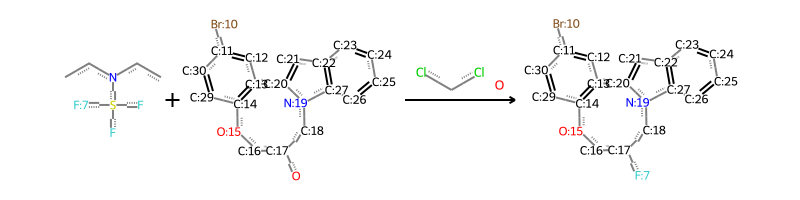

In [27]:
if reactions_with_dast:
    # Select the first reaction
    first_reaction = reactions_with_dast[0]

    # Generate a drawing of the reaction
    img = Draw.ReactionToImage(first_reaction)

    # Display the image in a Jupyter notebook or similar environment
    display(img)
else:
    print("No reactions containing DAST were found.")

In [39]:
c_h_template = AllChem.ReactionFromSmarts('[CH:1]>>[C:1]~[C:2]', useSmiles=True)
rxn = AllChem.ReactionFromSmarts('C1=[CH:1]-C=CC=C1.C[CH:2]=C.[Pd]>>C[C:2](=C)[CH:1]1=CC=CC=C1',useSmiles=True)

result = rdChemReactions.HasReactionSubstructMatch(rxn,c_h_template)
print(result) # returns True

True


In [54]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem import AllChem

# Define your SMARTS pattern for deoxofluorination
deoxofluoro_smarts = '[C:1][OH:2]>>[C:1][F:2]'
deoxofluoro_template = AllChem.ReactionFromSmarts(deoxofluoro_smarts)

def OH_to_F(reaction_objs):
    deoxofluoro_reactions = []
    for reaction in reaction_objs:
        # Sanitize each molecule in the reaction
        try:
            for reactant in reaction.GetReactants():
                Chem.SanitizeMol(reactant)
            for product in reaction.GetProducts():
                Chem.SanitizeMol(product)
            # Check for the substructure match after sanitization
            if rdChemReactions.HasReactionSubstructMatch(reaction, deoxofluoro_template):
                deoxofluoro_reactions.append(reaction)
        except Chem.rdchem.AtomValenceException as e:
            print(f"Valence exception for reaction: {Chem.ReactionToSmiles(reaction)}")
            print(str(e))
        except Chem.rdchem.AtomKekulizeException as e:
            print(f"Kekulization exception for reaction: {Chem.ReactionToSmiles(reaction)}")
            print(str(e))
        except Chem.rdchem.KekulizeException as e:
            print(f"Kekulization exception for reaction: {Chem.ReactionToSmiles(reaction)}")
            print(str(e))
    return deoxofluoro_reactions

# Assuming 'reactions_with_dast' is a list of ChemicalReaction objects
deoxofluoro_reactions = OH_to_F(reactions_with_dast)

print("Deoxofluorination reactions:")
for i, reaction in enumerate(deoxofluoro_reactions, 1):
    # Convert reaction object to SMILES for printing
    reaction_smiles = AllChem.ReactionToSmiles(reaction)
    print(f"Reaction {i}: {reaction_smiles}")


Deoxofluorination reactions:
Reaction 1: CCN(CC)S(F)(F)F.[CH3]C#C[CH2]Oc1[cH][cH]c([CH2][C@H]([NH]C(=O)[C@@H](/C=C/[CH2][CH2][CH2][CH2][CH2][CH2]C2([CH2][CH2][CH2][CH2][CH2][CH2][CH3])O[CH2][CH2]O2)[C@@]([OH])([CH2][CH2]O)C(=O)OC([CH3])([CH3])[CH3])C(=O)O[CH3])[cH][cH]1>C1CCOC1>[CH3]C#C[CH2]Oc1[cH][cH]c([CH2][C@H]([NH]C(=O)[C@@H](/C=C/[CH2][CH2][CH2][CH2][CH2][CH2]C2([CH2][CH2][CH2][CH2][CH2][CH2][CH3])O[CH2][CH2]O2)[C@@]([OH])([CH2][CH2]F)C(=O)OC([CH3])([CH3])[CH3])C(=O)O[CH3])[cH][cH]1
Reaction 2: CCN(CC)S(F)(F)F.[CH3]N1[CH2][CH2]C2=C([CH2]1)c1[cH]c([CH2][OH])[cH][cH]c1N2[CH2]C([CH3])(O)C1=[CH][CH]=[CH]N=[CH]1>ClCCl>[CH3]N1[CH2][CH2]C2=C([CH2]1)c1[cH]c([CH2][OH])[cH][cH]c1N2[CH2]C([CH3])(F)C1=[CH][CH]=[CH]N=[CH]1


In [57]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem import AllChem

# Define a more general SMARTS pattern for deoxofluorination
deoxofluoro_smarts = '[CX4H2][OH]>>[CX4H2][F]'
deoxofluoro_template = AllChem.ReactionFromSmarts(deoxofluoro_smarts)

def OH_to_F(reaction_objs):
    deoxofluoro_reactions = []
    for reaction in reaction_objs:
        # Sanitize each molecule in the reaction
        try:
            for reactant in reaction.GetReactants():
                Chem.SanitizeMol(reactant)
            for product in reaction.GetProducts():
                Chem.SanitizeMol(product)
            # Check for the substructure match after sanitization
            if rdChemReactions.HasReactionSubstructMatch(reaction, deoxofluoro_template):
                deoxofluoro_reactions.append(reaction)
        except Chem.rdchem.AtomValenceException as e:
            print(f"Valence exception for reaction: {Chem.ReactionToSmiles(reaction)}")
            print(str(e))
        except Chem.rdchem.AtomKekulizeException as e:
            print(f"Kekulization exception for reaction: {Chem.ReactionToSmiles(reaction)}")
            print(str(e))
        except Chem.rdchem.KekulizeException as e:
            print(f"Kekulization exception for reaction: {Chem.ReactionToSmiles(reaction)}")
            print(str(e))
    return deoxofluoro_reactions

# Assuming 'reactions_with_dast' is a list of ChemicalReaction objects
deoxofluoro_reactions = OH_to_F(reactions_with_dast)

print("Deoxofluorination reactions:")
for i, reaction in enumerate(deoxofluoro_reactions, 1):
    # Convert reaction object to SMILES for printing
    reaction_smiles = AllChem.ReactionToSmiles(reaction)
    print(f"Reaction {i}: {reaction_smiles}")

Deoxofluorination reactions:


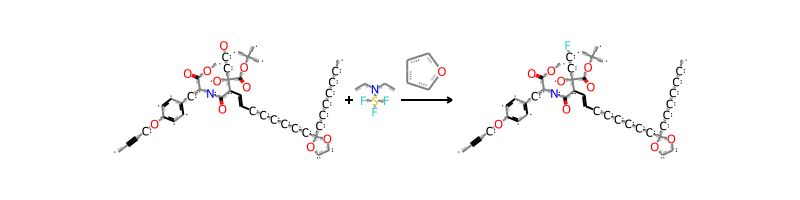

In [56]:
if deoxofluoro_reactions:
    # Select the first reaction
    first_reaction = deoxofluoro_reactions[0]

    # Clear atom-mapping numbers
    for reactant in first_reaction.GetReactants():
        for atom in reactant.GetAtoms():
            atom.SetAtomMapNum(0)
    for product in first_reaction.GetProducts():
        for atom in product.GetAtoms():
            atom.SetAtomMapNum(0)

    # Generate a drawing of the reaction
    img = Draw.ReactionToImage(first_reaction)

    # Display the image in a Jupyter notebook or similar environment
    display(img)
else:
    print("No reactions containing DAST were found.")

In [58]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem import AllChem

def OH_to_F(reaction_objs):
    # SMARTS pattern to detect a hydroxyl group attached to any carbon
    oh_smarts = '[CX4][OH]'
    oh_mol = Chem.MolFromSmarts(oh_smarts)
    
    # SMARTS pattern to detect a fluorine atom attached to any carbon
    f_smarts = '[CX4][F]'
    f_mol = Chem.MolFromSmarts(f_smarts)
    
    deoxofluoro_reactions = []
    for reaction in reaction_objs:
        # Convert reaction object to SMILES for comparison
        reaction_smiles = AllChem.ReactionToSmiles(reaction)
        
        reactants, products = reaction_smiles.split('>>')
        reactants_mols = [Chem.MolFromSmiles(reactant) for reactant in reactants.split('.')]
        products_mols = [Chem.MolFromSmiles(product) for product in products.split('.')]
        
        # Check for loss of OH group in any reactant and gain of F in any product
        oh_loss = any(reactant.HasSubstructMatch(oh_mol) for reactant in reactants_mols)
        f_gain = any(product.HasSubstructMatch(f_mol) for product in products_mols)
        
        if oh_loss and f_gain:
            # Append the original reaction object
            deoxofluoro_reactions.append(reaction)
    
    return deoxofluoro_reactions

# Assuming 'reactions_with_dast' is a list of ChemicalReaction objects
deoxofluoro_reactions = OH_to_F(reactions_with_dast)

print("Deoxofluorination reactions:")
for i, reaction in enumerate(deoxofluoro_reactions, 1):
    # Convert reaction object to SMILES for printing
    reaction_smiles = AllChem.ReactionToSmiles(reaction)
    print(f"Reaction {i}: {reaction_smiles}")

ValueError: not enough values to unpack (expected 2, got 1)

In [60]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem import AllChem

def OH_to_F(reaction_objs):
    # SMARTS pattern to detect a hydroxyl group attached to any carbon
    oh_smarts = '[CX4][OH]'
    oh_mol = Chem.MolFromSmarts(oh_smarts)
    
    # SMARTS pattern to detect a fluorine atom attached to any carbon
    f_smarts = '[CX4][F]'
    f_mol = Chem.MolFromSmarts(f_smarts)
    
    deoxofluoro_reactions = []
    for reaction in reaction_objs:
        # Convert reaction object to SMILES for comparison
        reaction_smiles = AllChem.ReactionToSmiles(reaction)
        
        # Split reaction into parts. It could contain reagents or not.
        parts = reaction_smiles.split('>')
        if len(parts) == 3:
            reactants, reagents, products = parts
        elif len(parts) == 2:
            reactants, products = parts
        else:
            print("Unexpected reaction format:", reaction_smiles)
            continue

        # Convert reactant and product parts to molecule objects
        reactants_mols = [Chem.MolFromSmiles(reactant) for reactant in reactants.split('.')]
        products_mols = [Chem.MolFromSmiles(product) for product in products.split('.')]
        
        # Check for loss of OH group in any reactant and gain of F in any product
        oh_loss = any(reactant.HasSubstructMatch(oh_mol) for reactant in reactants_mols)
        f_gain = any(product.HasSubstructMatch(f_mol) for product in products_mols)
        
        if oh_loss and f_gain:
            deoxofluoro_reactions.append(reaction)
    
    return deoxofluoro_reactions

# Assuming 'reactions_with_dast' is a list of ChemicalReaction objects
deoxofluoro_reactions = OH_to_F(reactions_with_dast)

print("Deoxofluorination reactions:")
for i, reaction in enumerate(deoxofluoro_reactions, 1):
    # Convert reaction object to SMILES for printing
    reaction_smiles = AllChem.ReactionToSmiles(reaction)
    print(f"Reaction {i}: {reaction_smiles}")


Deoxofluorination reactions:
Reaction 1: CCN(CC)S(F)(F)[F:7].O[CH:17]1[CH2:16][O:15][c:14]2[c:13]([cH:12][c:11]([Br:10])[cH:30][cH:29]2)[C:20]2=[CH:21][c:22]3[cH:23][cH:24][cH:25][cH:26][c:27]3[N:19]2[CH2:18]1>ClCCl.O>[F:7][CH:17]1[CH2:16][O:15][c:14]2[c:13]([cH:12][c:11]([Br:10])[cH:30][cH:29]2)[C:20]2=[CH:21][c:22]3[cH:23][cH:24][cH:25][cH:26][c:27]3[N:19]2[CH2:18]1
Reaction 2: CCN(CC)S(F)(F)[F:7].O[CH2:28][CH:26]1[N:17]2[C:16](=[CH:24][c:23]3[c:18]2[cH:19][cH:20][cH:21][c:22]3[F:25])[C:15]2=[C:14]([CH:13]=[CH:12][C:11]([Cl:10])=[N:30]2)[O:27]1>ClCCl.O>[F:7][CH2:28][CH:26]1[N:17]2[C:16](=[CH:24][c:23]3[c:18]2[cH:19][cH:20][cH:21][c:22]3[F:25])[C:15]2=[C:14]([CH:13]=[CH:12][C:11]([Cl:10])=[N:30]2)[O:27]1
Reaction 3: CCN(CC)S(F)(F)F.[CH3]C#C[CH2]Oc1[cH][cH]c([CH2][C@H]([NH]C(=O)[C@@H](/C=C/[CH2][CH2][CH2][CH2][CH2][CH2]C2([CH2][CH2][CH2][CH2][CH2][CH2][CH3])O[CH2][CH2]O2)[C@@]([OH])([CH2][CH2]O)C(=O)OC([CH3])([CH3])[CH3])C(=O)O[CH3])[cH][cH]1>C1CCOC1>[CH3]C#C[CH2]Oc1[cH][cH]c([CH2][C@H

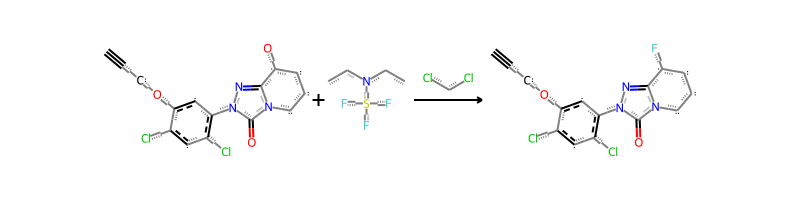

In [63]:
if deoxofluoro_reactions:
    # Select the first reaction
    first_reaction = deoxofluoro_reactions[20]

    # Clear atom-mapping numbers
    for reactant in first_reaction.GetReactants():
        for atom in reactant.GetAtoms():
            atom.SetAtomMapNum(0)
    for product in first_reaction.GetProducts():
        for atom in product.GetAtoms():
            atom.SetAtomMapNum(0)

    # Generate a drawing of the reaction
    img = Draw.ReactionToImage(first_reaction)

    # Display the image in a Jupyter notebook or similar environment
    display(img)
else:
    print("No reactions containing DAST were found.")

In [67]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem import AllChem

def OH_to_F(reaction_objs):
    # SMARTS pattern to detect a hydroxyl group attached to any carbon
    oh_smarts = '[CX4][OH]'
    oh_mol = Chem.MolFromSmarts(oh_smarts)
    
    # SMARTS pattern to detect a fluorine atom attached to any carbon
    f_smarts = '[CX4][F]'
    f_mol = Chem.MolFromSmarts(f_smarts)
    
    deoxofluoro_reactions = []
    for reaction in reaction_objs:
        reaction_smiles = AllChem.ReactionToSmiles(reaction)
        
        # Split reaction into parts. It could contain reagents or not.
        parts = reaction_smiles.split('>')
        if len(parts) == 3:
            reactants, reagents, products = parts
        elif len(parts) == 2:
            reactants, products = parts
        else:
            print("Unexpected reaction format:", reaction_smiles)
            continue

        # Convert reactant and product parts to molecule objects, checking for validity
        reactants_mols = [Chem.MolFromSmiles(reactant) for reactant in reactants.split('.') if Chem.MolFromSmiles(reactant)]
        products_mols = [Chem.MolFromSmiles(product) for product in products.split('.') if Chem.MolFromSmiles(product)]

        if not reactants_mols or not products_mols:
            print("Failed to parse one or more molecules in the reaction:", reaction_smiles)
            continue
        
        # Check for loss of OH group in any reactant and gain of F in any product
        oh_loss = any(reactant.HasSubstructMatch(oh_mol) for reactant in reactants_mols)
        f_gain = any(product.HasSubstructMatch(f_mol) for product in products_mols)
        
        if oh_loss and f_gain:
            deoxofluoro_reactions.append(reaction)
    
    return deoxofluoro_reactions

# Assuming 'reactions_with_dast' is a list of ChemicalReaction objects
deoxofluoro_reactions = OH_to_F(fluor_compounds)

print("Deoxofluorination reactions:")
for i, reaction in enumerate(deoxofluoro_reactions, 1):
    reaction_smiles = AllChem.ReactionToSmiles(reaction)
    print(f"Reaction {i}: {reaction_smiles}")


[21:56:02] WARNING: not removing hydrogen atom without neighbors
[21:56:02] WARNING: not removing hydrogen atom without neighbors
[21:56:02] WARNING: not removing hydrogen atom without neighbors
[21:56:02] WARNING: not removing hydrogen atom without neighbors
[21:56:02] WARNING: not removing hydrogen atom without neighbors
[21:56:02] WARNING: not removing hydrogen atom without neighbors
[21:56:02] WARNING: not removing hydrogen atom without neighbors
[21:56:02] WARNING: not removing hydrogen atom without neighbors
[21:56:02] WARNING: not removing hydrogen atom without neighbors
[21:56:02] WARNING: not removing hydrogen atom without neighbors
[21:56:02] WARNING: not removing hydrogen atom without neighbors
[21:56:02] WARNING: not removing hydrogen atom without neighbors
[21:56:02] WARNING: not removing hydrogen atom without neighbors
[21:56:02] WARNING: not removing hydrogen atom without neighbors
[21:56:02] WARNING: not removing hydrogen atom without neighbors
[21:56:02] WARNING: not r

Deoxofluorination reactions:
Reaction 1: ClCCCl.O[C:37]([CH2:36][NH:35][C:33]([O:32][C:28]([CH3:29])([CH3:30])[CH3:31])=[O:34])=[O:38].[Cl:1][C:2]1=[C:7]([CH2:8][C@H:9]([OH:10])[C:11]2=[CH:12][C:13]([O:21][CH2:22][CH:23]3[CH2:24][CH2:25]3)=[C:14]([O:17][CH:18]([F:19])[F:20])[CH:15]=[CH:16]2)[C:6]([Cl:26])=[CH:5][N+:4]([O-:27])=[CH:3]1>CN(C)C1=CC=NC=C1.CN(C)C=O.O>[Cl:1][C:2]1=[C:7]([CH2:8][C@H:9]([O:10][C:37]([CH2:36][NH:35][C:33]([O:32][C:28]([CH3:29])([CH3:30])[CH3:31])=[O:34])=[O:38])[C:11]2=[CH:12][C:13]([O:21][CH2:22][CH:23]3[CH2:24][CH2:25]3)=[C:14]([O:17][CH:18]([F:19])[F:20])[CH:15]=[CH:16]2)[C:6]([Cl:26])=[CH:5][N+:4]([O-:27])=[CH:3]1
Reaction 2: ClCCCl.O[C:43]([CH2:42][CH2:41][S:38]([C:32]1=[CH:33][CH:34]=[CH:35][CH:36]=[CH:37]1)(=[O:39])=[O:40])=[O:44].[O-][N+:4]1=[CH:3][C:2]([Cl:1])=[C:7]([CH2:8][C@H:9]([OH:10])[C:11]2=[CH:12][C:13]([O:21][CH2:22][CH:23]3[CH2:24][CH2:25]3)=[C:14]([O:17][CH:18]([F:19])[F:20])[CH:15]=[CH:16]2)[C:6]([Cl:26])=[CH:5]1>CN(C)C1=CC=NC=C1.ClCCl>[Cl:1

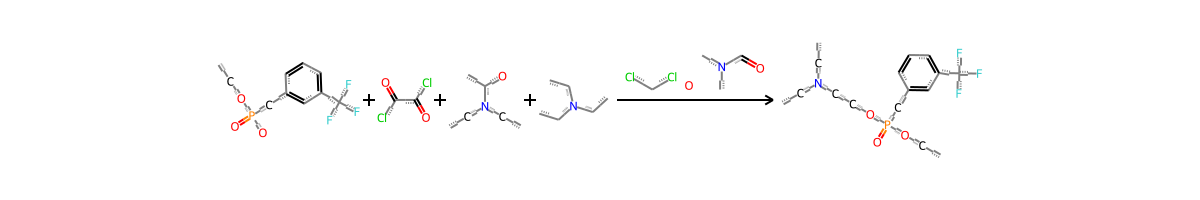

In [73]:
if deoxofluoro_reactions:
    # Select the first reaction
    first_reaction = deoxofluoro_reactions[1001]

    # Clear atom-mapping numbers
    for reactant in first_reaction.GetReactants():
        for atom in reactant.GetAtoms():
            atom.SetAtomMapNum(0)
    for product in first_reaction.GetProducts():
        for atom in product.GetAtoms():
            atom.SetAtomMapNum(0)

    # Generate a drawing of the reaction
    img = Draw.ReactionToImage(first_reaction)

    # Display the image in a Jupyter notebook or similar environment
    display(img)
else:
    print("No reactions containing DAST were found.")